## Imports and Loads

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_ind

from econml.dml import LinearDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

In [2]:
data_folder = './data/'
pickle_folder = data_folder + 'pickle/'
imdb_folder = data_folder + 'IMDB/'
cmu_folder = data_folder + 'CMU/'

In [ ]:
# Load the data
with open(pickle_folder + 'movies_clean.p', 'rb') as f:
    movie_data = pickle.load(f)

In [4]:
movie_data

,Wikipedia_movie_ID,Movie_name,Movie_box_office_revenue,Year,Year_Interval,nb_of_Genres,Genre_Action,Genre_Action/Adventure,Genre_Adventure,Genre_Animation,...,Country_Germany,Country_Hong Kong,Country_India,Country_Italy,Country_Japan,Country_Other,Country_United Kingdom,Country_United States of America,averageRating,numVotes
0,3217,Army of Darkness,21502796.0,1992,1970-2000,12,True,True,False,False,...,False,False,False,False,False,False,False,True,7.4,197717.0
1,3333,The Birth of a Nation,50000000.0,1915,1915-1930,7,False,False,False,False,...,False,False,False,False,False,False,False,True,6.1,26681.0
2,3746,Blade Runner,33139618.0,1982,1970-2000,12,False,False,False,False,...,False,True,False,False,False,False,False,True,8.1,835060.0
3,3837,Blazing Saddles,119500000.0,1974,1970-2000,3,False,False,False,False,...,False,False,False,False,False,False,False,True,7.7,155432.0
4,3947,Blue Velvet,8551228.0,1986,1970-2000,3,False,False,False,False,...,False,False,False,False,False,False,False,True,7.7,219742.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34784,36674310,Mystery of Marie Roget,NaN,1942,1930-1950,1,False,False,False,False,...,False,False,False,False,False,False,False,True,5.9,371.0
34785,36683360,2016: Obama's America,33449086.0,2012,2000-2015,1,False,False,False,False,...,False,False,False,False,False,False,False,True,4.8,11049.0
34786,36814246,Eraserhead,7000000.0,1977,1970-2000,10,False,False,False,False,...,False,False,False,False,False,False,False,True,7.3,130107.0
34788,36929245,Before Midnight,NaN,2013,2000-2015,2,False,False,False,False,...,False,False,False,False,False,False,False,True,7.9,175072.0


## Propensity Score Calculation

Propensity scores represent the probability of a movie being "treated" (having multiple languages). These scores are calculated based on observable covariates such as:
- Number of genres
- Average rating
- Release year
- Number of votes

The scores help to balance the treated and control groups by accounting for confounding variables.


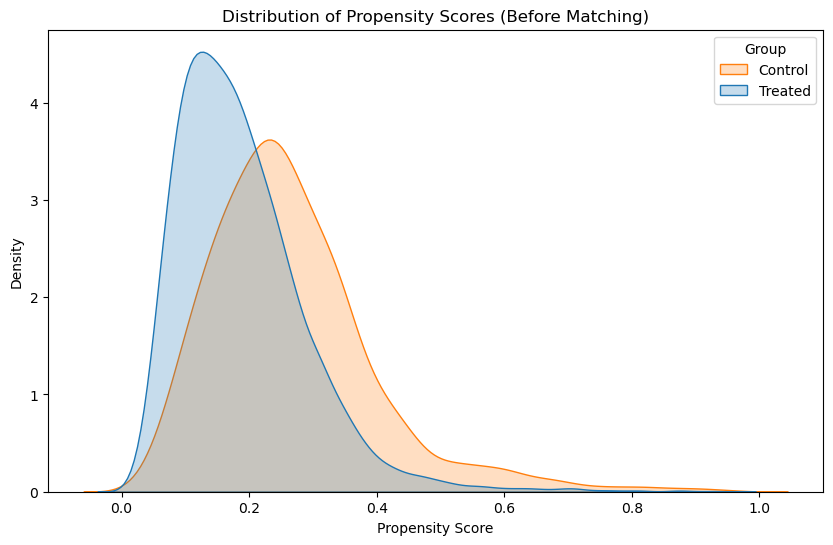

In [5]:

# prepare the data
columns_of_interest = ['Movie_box_office_revenue', 'Year', 'nb_of_Genres', 'averageRating', 'numVotes', 'nb_of_Languages']
filtered_data = movie_data[columns_of_interest].dropna()

# Define treated and control groups based on the number of languages
language_threshold = 1
filtered_data['treated'] = (filtered_data['nb_of_Languages'] > language_threshold).astype(int)

# Calculate propensity scores using logistic regression
X = filtered_data[['Year', 'nb_of_Genres', 'averageRating', 'numVotes']]
y = filtered_data['treated']

# Normalize features
X_normalized = (X - X.mean()) / X.std()

# Train logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_normalized, y)

# Add propensity scores to the dataset
filtered_data['propensity_score'] = logistic_model.predict_proba(X_normalized)[:, 1]

# Plot propensity score distributions before matching
plt.figure(figsize=(10, 6))
sns.kdeplot(data=filtered_data, x='propensity_score', hue='treated', fill=True, common_norm=False)
plt.title('Distribution of Propensity Scores (Before Matching)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Group', labels=['Control', 'Treated'])
plt.show()




## Matching

Movies are matched based on their propensity scores using a nearest neighbor matching algorithm. This ensures that treated and control movies are comparable, reducing selection bias.

Matched groups are then used to compare the outcomes, such as box office revenue.


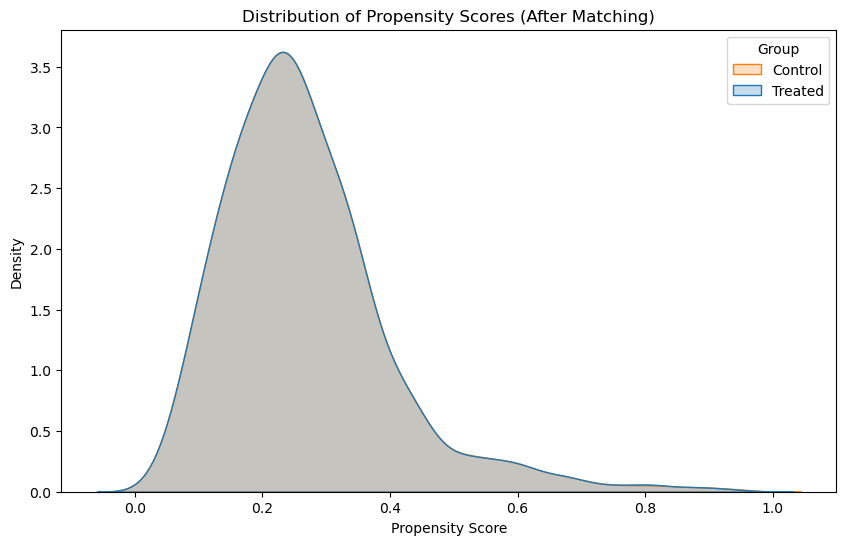

In [6]:
# Perform matching based on propensity scores
treated = filtered_data[filtered_data['treated'] == 1]
control = filtered_data[filtered_data['treated'] == 0]

# Use nearest neighbors for matching
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Apply caliper to filter matches
caliper = 0.05
matched_indices = indices[distances.flatten() < caliper]
matched_control = control.iloc[matched_indices.flatten()]
matched_treated = treated.iloc[distances.flatten() < caliper]
matched_data = pd.concat([matched_treated, matched_control])

# Plot propensity score distributions after matching
plt.figure(figsize=(10, 6))
sns.kdeplot(data=matched_data, x='propensity_score', hue='treated', fill=True, common_norm=False)
plt.title('Distribution of Propensity Scores (After Matching)')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Group', labels=['Control', 'Treated'])
plt.show()



#### Revenue and Rating Analysis by Year 


In [ ]:
# Calculate average outcomes by year
years = sorted(matched_data['Year'].unique())
mean_revenues_treated = []
mean_revenues_control = []
mean_ratings_treated = []
mean_ratings_control = []

for year in years:
    # Filter data up to the current year
    subset = matched_data[matched_data['Year'] <= year]
    treated_subset = subset[subset['treated'] == 1]
    control_subset = subset[subset['treated'] == 0]
    
    # Calculate average revenue for treated and control groups
    mean_revenues_treated.append(treated_subset['Movie_box_office_revenue'].mean())
    mean_revenues_control.append(control_subset['Movie_box_office_revenue'].mean())
    
    # Calculate average rating for treated and control groups
    mean_ratings_treated.append(treated_subset['averageRating'].mean())
    mean_ratings_control.append(control_subset['averageRating'].mean())



#### Confidence Intervals


In [32]:
# Calculate Confidence Intervals for revenue
ci_revenues_treated = []
ci_revenues_control = []

for year in years:
    subset = matched_data[matched_data['Year'] <= year]
    treated_subset = subset[subset['treated'] == 1]
    control_subset = subset[subset['treated'] == 0]

    # Calculate CI for treated group
    treated_std = treated_subset['Movie_box_office_revenue'].std()
    treated_count = len(treated_subset)
    ci_revenues_treated.append(1.96 * (treated_std / np.sqrt(treated_count)))

    # Calculate CI for control group
    control_std = control_subset['Movie_box_office_revenue'].std()
    control_count = len(control_subset)
    ci_revenues_control.append(1.96 * (control_std / np.sqrt(control_count)))

# Calculate Confidence Intervals for average rating
ci_ratings_treated = []
ci_ratings_control = []

for year in years:
    subset = matched_data[matched_data['Year'] <= year]
    treated_subset = subset[subset['treated'] == 1]
    control_subset = subset[subset['treated'] == 0]

    # Calculate CI for treated group
    treated_std = treated_subset['averageRating'].std()
    treated_count = len(treated_subset)
    ci_ratings_treated.append(1.96 * (treated_std / np.sqrt(treated_count)))

    # Calculate CI for control group
    control_std = control_subset['averageRating'].std()
    control_count = len(control_subset)
    ci_ratings_control.append(1.96 * (control_std / np.sqrt(control_count)))


In [ ]:
fig_revenue = go.Figure()

# set the starting year at 1940 for significant results
start_index = years.index(1940)
filtered_years = years[start_index:]

# Calculate the middle index 
mid_index = len(filtered_years) // 2
active_index = start_index + mid_index 

# Add bars for treated and control groups 
fig_revenue.add_trace(go.Bar(
    x=['Treated', 'Control'],
    y=[mean_revenues_treated[active_index], mean_revenues_control[active_index]],  
    error_y=dict(
        type='data',
        array=[ci_revenues_treated[active_index], ci_revenues_control[active_index]],  
        visible=True
    ),
    name=f'Year: {filtered_years[mid_index]}',  
    marker_color=['blue', 'red']
))

# Add a slider for years 
steps_revenue = []
for i in range(start_index, len(years)):
    step = dict(
        method="update",
        args=[
            {"y": [[mean_revenues_treated[i], mean_revenues_control[i]]],  # Update revenue data
             "error_y.array": [[ci_revenues_treated[i], ci_revenues_control[i]]]},  # Update error bars
            {"title": f"Year: {years[i]}"}  # Update the title
        ],
        label=str(years[i])
    )
    steps_revenue.append(step)

sliders_revenue = [dict(
    active=mid_index,  
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps_revenue
)]

fig_revenue.update_layout(
    sliders=sliders_revenue,
    title=f"Mean Box Office Revenue (Matched Samples) - Year: {filtered_years[mid_index]}",
    yaxis=dict(title="Mean Box Office Revenue"),
    xaxis=dict(title="Group"),
    showlegend=False
)

fig_revenue.show()


The figure above compares the average box office revenues of treated and control groups over time. The Treated movies consistently outperform controls in recent decades which was not the case a long time before.

In [ ]:
# Filter years starting from 1930 for significant results
start_index = years.index(1930)
filtered_years = years[start_index:]

# Filter mean difference and confidence intervals 
filtered_mean_difference_revenue = np.abs(
    np.nan_to_num(mean_revenues_treated[start_index:], nan=0) - 
    np.nan_to_num(mean_revenues_control[start_index:], nan=0)
)
filtered_ci_upper_revenue = np.nan_to_num(
    filtered_mean_difference_revenue + 
    np.array(ci_revenues_treated[start_index:]) + 
    np.array(ci_revenues_control[start_index:]), 
    nan=0
)
filtered_ci_lower_revenue = np.nan_to_num(
    filtered_mean_difference_revenue - 
    (np.array(ci_revenues_treated[start_index:]) + 
     np.array(ci_revenues_control[start_index:])), 
    nan=0
)

# Define the position of the dot 
mid_index = len(filtered_years) // 2
initial_year = filtered_years[mid_index]
initial_value = filtered_mean_difference_revenue[mid_index]

fig_revenue_curve = go.Figure()

# Add the main line
fig_revenue_curve.add_trace(go.Scatter(
    x=filtered_years,
    y=filtered_mean_difference_revenue,
    mode='lines',
    name='Mean Difference (Revenue)',
    line=dict(color='blue')
))

# Add the confidence interval as a filled area
fig_revenue_curve.add_trace(go.Scatter(
    x=np.concatenate([filtered_years, filtered_years[::-1]]),
    y=np.concatenate([filtered_ci_upper_revenue, filtered_ci_lower_revenue[::-1]]),
    fill='toself',
    fillcolor='rgba(0, 0, 255, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    showlegend=True,
    name='95% CI'
))

# Add the red dot 
fig_revenue_curve.add_trace(go.Scatter(
    x=[initial_year],
    y=[initial_value],
    mode='markers+text',
    marker=dict(color='red', size=10),
    text=[f"{initial_year}: {initial_value:.2f} USD"],
    textposition="top center",
    name="Year Marker"
))

# Create the slider
steps_revenue_curve = []
for i in range(len(filtered_years)):
    step = dict(
        method='update',
        args=[
            # Update the position of the dot
            {'x': [filtered_years, np.concatenate([filtered_years, filtered_years[::-1]]), [filtered_years[i]]],
             'y': [filtered_mean_difference_revenue,
                   np.concatenate([filtered_ci_upper_revenue, filtered_ci_lower_revenue[::-1]]),
                   [filtered_mean_difference_revenue[i]]],
             'text': [None, None, [f"{filtered_years[i]}: {filtered_mean_difference_revenue[i]:.2f} USD"]]},  # Update text
        ],
        label=str(filtered_years[i])
    )
    steps_revenue_curve.append(step)

# Add slider configuration
fig_revenue_curve.update_layout(
    sliders=[dict(
        active=mid_index,  
        currentvalue={"prefix": "Year: "},
        pad={"t": 50},
        steps=steps_revenue_curve
    )],
    title="Mean Difference (Treated - Control)",
    xaxis=dict(title="Year"),
    yaxis=dict(title="Mean Difference (USD)"),
    showlegend=True
)

fig_revenue_curve.show()



The results indicate that multilingual movies consistently generate higher box office revenues compared to single-language movies. The positive mean difference, particularly after 1940 (may correspond to historical shifts in the movie industry), suggests a persistent and statistically significant treatment effect .

In [ ]:
# Set start year at 1940
start_index = years.index(1940)
filtered_years = years[start_index:]

# Calculate the middle index 
mid_index = len(filtered_years) // 2
active_index = start_index + mid_index  

fig_rating = go.Figure()

# Add bars for treated and control groups 
fig_rating.add_trace(go.Bar(
    x=['Treated', 'Control'],
    y=[mean_ratings_treated[active_index], mean_ratings_control[active_index]],  
    error_y=dict(
        type='data',
        array=[ci_ratings_treated[active_index], ci_ratings_control[active_index]],  
        visible=True
    ),
    name=f'Year: {filtered_years[mid_index]}',  
    marker_color=['blue', 'red']
))

# Add a slider
steps_rating = []
for i in range(start_index, len(years)):
    step = dict(
        method="update",
        args=[
            {"y": [[mean_ratings_treated[i], mean_ratings_control[i]]],  # Update rating data
             "error_y.array": [[ci_ratings_treated[i], ci_ratings_control[i]]]},  # Update error bars
            {"title": f"Year: {years[i]}"}  # Update the title
        ],
        label=str(years[i])
    )
    steps_rating.append(step)

sliders_rating = [dict(
    active=mid_index,  
    currentvalue={"prefix": "Year: "},
    pad={"t": 50},
    steps=steps_rating
)]

fig_rating.update_layout(
    sliders=sliders_rating,
    title=f"Year: {filtered_years[mid_index]}",  
    yaxis=dict(title="Mean Average Rating"),
    xaxis=dict(title="Group"),
    showlegend=False
)

fig_rating.show()


The graph compares the mean average ratings between treated and control groups. The similarity in mean ratings over years suggests that the difference in ratings is not statistically significant in this case.

#### T-Test 

In [36]:

# T-test for revenue
t_stat_revenue, p_value_revenue = ttest_ind(matched_treated['Movie_box_office_revenue'], matched_control['Movie_box_office_revenue'])
print(f"Revenue: T-statistic = {t_stat_revenue:.2f}, P-value = {p_value_revenue:.4f}")

# T-test for average rating
t_stat_rating, p_value_rating = ttest_ind(matched_treated['averageRating'], matched_control['averageRating'])
print(f"Average Rating: T-statistic = {t_stat_rating:.2f}, P-value = {p_value_rating:.4f}")


Revenue: T-statistic = 3.72, P-value = 0.0002
Average Rating: T-statistic = -0.43, P-value = 0.6671


The T-test compares the mean revenues of treated and control groups to assess the treatment effect. The treatment effect on revenue is statistically significant since the P-value is low, while the effect on average ratings is negligible.

## Double Machine Learning (DML)

DML is used to estimate the Average Treatment Effect (ATE) more precisely by incorporating machine learning models to control for confounding variables. In this analysis:
- The treatment is defined as having multiple languages.
- The outcome is box office revenue.

In [ ]:

# Define the outcome, treatment and covariates
Y = matched_data['Movie_box_office_revenue'].values  # Outcome (Revenue)
T = matched_data['treated'].values  
X = matched_data[['Year', 'nb_of_Genres', 'averageRating', 'numVotes']]  # Covariates

# Initialize the DML model
dml = LinearDML(
    model_y=RandomForestRegressor(),  # Model for outcome regression
    model_t=RandomForestRegressor(),  # Model for treatment regression
    linear_first_stages=False
)

# Fit the model
dml.fit(Y, T, X=X, W=None)

# Estimate the treatment effect
att_dml = dml.effect(X)
print(f"Estimated ATT (Double Machine Learning): {att_dml.mean():.2f}")


Estimated ATT (Double Machine Learning): 5316970.85


Movies with multiple languages generate an average additional revenue of $5.32 million, highlighting the substantial financial advantage of multilingual films.